# 2015年度長浜健康ウォークの解析

## 全体の狙い

現状の音声認識の枠組みを応用して、

1. 様々なヘルスレコードを統合的な特徴量に変換する手法を作れるか検討する
2. ユーザの内部状態（行動変容ステージ）推定をおこなえるかどうか検討する。
3. ヘルスケアエージェントの行動遷移モデルを（半）自動生成する枠組みを作れるかを検討する

うち、今回の解析では、1,2を行う。

## 音声認識の枠組み

![音声認識の仕組み](https://github.com/MxD-lab/healthrecord_analysis/wiki/images/asr.png)

## 提案予定のエージェントシステムの枠組み（ざっくり）

![エージェントシステムの枠組み](https://github.com/MxD-lab/healthrecord_analysis/wiki/images/agentsys.png)

## 今回の取り組み

### 様々なヘルスレコードを統合的な特徴量に変換する手法の検討

* 低次元化
	* 主成分分析（主に可視化のため）
	* Deep Sparse Autoencoder（こちらが本命）
* クラスタリング
	* Mean Shift クラスタリング
		* 確率密度の極大部を探索するMeanShift法を用いたクラスタリング。カーネル幅を指定することで、いくつのクラスタが存在するかを求めることができる
		* K-meanのようにkの値を指定しなくて良い

### ユーザの内部状態（行動変容ステージ）推定の検討

* ユーザ状態の推定
	* ユーザの状態推移をマルコフ連鎖と仮定
	* GMM-HMMにて推定
	* 特徴量をGMM近似して、そこからHMMの推定に持ち込む


## データセットの作成 - 前処理

* 各個人のヘルスレコードを240次元のデータセットに変換
	* 1日を24時間に分割
	* 24時間 x 10日分のステップデータの配列を作成
	* Activityのstepsを時間分割
		* その時間に占めるstep数 / 全体のstep数

![Step数も時間分割](https://github.com/MxD-lab/healthrecord_analysis/wiki/images/step_sequence.png)

In [ ]:
### see create_datasets.py

## チャレンジ全日程のパターン解析

### データの可視化

作成したデータセットからランダムに選び出した9つのデータを可視化してみる。

In [1]:
%matplotlib inline

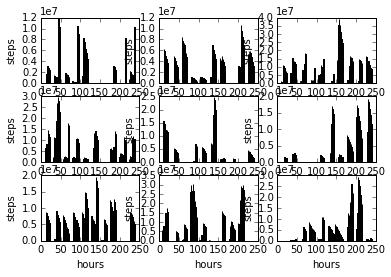

In [3]:
import random
import numpy
import matplotlib.pylab as plt

f = open('datasets.npz', 'rb')
dataset = numpy.load(f)
X = dataset['all']

f, axes = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        dataset = X[random.randint(0, X.shape[0] - 1)]
        # print 'dataset: ', dataset
        axes[i][j].bar(xrange(240), dataset)
        axes[i][j].set_xlabel('hours')
        axes[i][j].set_ylabel('steps')
plt.show()

### アニメーションの定義

3Dプロットを回しながら見るため、簡単なビデオタグの実装をします。

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from tempfile import NamedTemporaryFile
from IPython.display import HTML


VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

### 主成分分析

240次元のデータセットを主成分分析し、3次元プロットする。

In [5]:
import numpy
import matplotlib
from matplotlib import animation
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn.cluster import MeanShift, estimate_bandwidth

f = open('datasets.npz', 'rb')
dataset = numpy.load(f)
X = dataset['all']

fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='b', cmap=plt.cm.spectral)

def animate(nframe):
    ax.view_init(elev=10., azim=5. * nframe)

anim = animation.FuncAnimation(fig, animate, frames=int(360 / 5), blit=True)
display_animation(anim)

/Users/sugiyama/.anyenv/envs/pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


### MeanShiftクラスタリング

確率密度の極大部を探索するMeanShift法を用いたクラスタリングを使って上記のクラスタリングを行う。カーネル幅を指定することで、いくつのクラスタが存在するかを求めることができる。今回は、quantile=0.05を用いる

In [6]:
from itertools import cycle
import numpy
from sklearn.cluster import MeanShift
from sklearn.cluster import MeanShift, estimate_bandwidth

from matplotlib import animation
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig)

bandwidth = estimate_bandwidth(X, 0.05, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

labels = ms.labels_
# cluster_centers = ms.cluster_centers_
labels_unique = numpy.unique(labels)
n_clusters_ = len(labels_unique)
print 'n_clusters_: ', n_clusters_

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    # cluster_center = cluster_centers[k]
    ax.scatter(
        X[my_members, 0],
        X[my_members, 1],
        X[my_members, 2],
        c=col,
        cmap=plt.cm.spectral
    )


anim_clustering = animation.FuncAnimation(fig, animate, frames=int(360 / 5), blit=True)

display_animation(anim_clustering)

n_clusters_:  36


## データの前処理 Ver.2: Deep Sparse Autoencoderによる特徴量抽出

240次元から7層のDSAで30次元まで次元圧縮する

* Autoencoder:
	* 非教師学習による次元圧縮のためのニューラルネットワーク
* Sparse Autoencoder:
	* フィードフォワードニューラルネットワークの学習において汎化能力を高めるため、正則化項を追加したオートエンコーダのこと。ただし、ネットワークの重みではなく、中間層の値自体を0に近づける
	* より少ない(Sparseな)特徴量で入力を表現するように学習を行うため、クラスタリングのような効果を持つ
* Deep Autoencoder:
	* Autoencoderを多層化したもの

### Deep sparse autoencoderによる特徴量抽出



In [7]:
import logging

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

from dnn.SDA import SDA

#logging.basicConfig(level=logging.INFO)

f = open('datasets.npz', 'rb')
dataset = numpy.load(f)
X = dataset['all']

X = normalize(X)
sda = SDA.pretrain(
    [X, X],
    hiddens=[120, 60, 30],
    epochs=100
)
dataset_x = sda.get_hidden_values(X)
print 'dataset_x: ', dataset_x.shape, dataset_x[:10]

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13


/Users/sugiyama/.anyenv/envs/pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/sugiyama/.anyenv/envs/pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/chainer/function_set.py:62: FutureWarning: 'collect_parameters' is deprecated. You can pass FunctionSet itself to 'optimizer.setup'
  warnings.warn(msg, FutureWarning)


ValueError: given link is already registered to another chain by name encoder

NameError: name 'dataset_x' is not defined

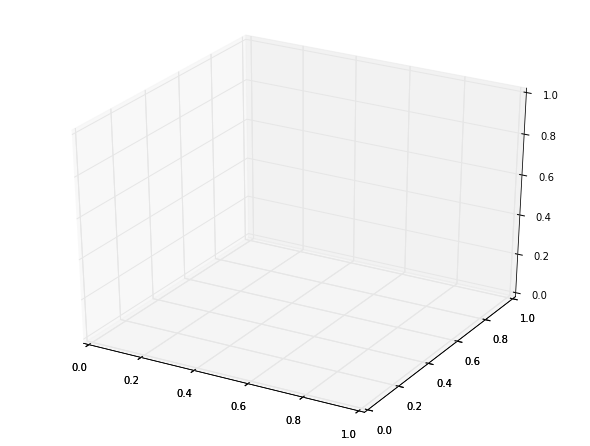

In [8]:
import numpy
import matplotlib
from matplotlib import animation
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn.cluster import MeanShift, estimate_bandwidth

fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(dataset_x)
X = pca.transform(dataset_x)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='b', cmap=plt.cm.spectral)

def animate(nframe):
    ax.view_init(elev=10., azim=5. * nframe)

anim = animation.FuncAnimation(fig, animate, frames=int(360 / 5), blit=True)
display_animation(anim)

In [ ]:
X = pca.transform(dataset_x)

fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig)

bandwidth = estimate_bandwidth(X, 0.05, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

labels = ms.labels_
# cluster_centers = ms.cluster_centers_
labels_unique = numpy.unique(labels)
n_clusters_ = len(labels_unique)
print 'n_clusters_: ', n_clusters_

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    # cluster_center = cluster_centers[k]
    ax.scatter(
        X[my_members, 0],
        X[my_members, 1],
        X[my_members, 2],
        c=col,
        cmap=plt.cm.spectral
    )


anim_clustering = animation.FuncAnimation(fig, animate, frames=int(360 / 5), blit=True)

display_animation(anim_clustering)

## チャレンジ3日間ごとのパターン解析

### データの前処理

* 各個人のヘルスレコードを240次元のデータセットに変換
* 上記のデータを72時間を窓幅として24時間毎にスライド
* これにDSAを適用し、18次元に低次元化
	* データ数：5632
	* 次元数：18


In [ ]:
## ３つに分けるコードを後で書く

### 低次元化

In [ ]:
f = open('datasets.npz', 'rb')
dataset = numpy.load(f)
X = dataset['3']

X = normalize(X)
sda = SDA.pretrain(
    [X, X],
    hiddens=[72, 36, 18],
    epochs=100
)
dataset_x = sda.get_hidden_values(X)
print 'dataset_x: ', dataset_x.shape, dataset_x[:10]

### 主成分分析

3次元の主成分分析にかけ、プロット(3クラスタ)

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(dataset_x)
X = pca.transform(dataset_x)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='b', cmap=plt.cm.spectral)

def animate(nframe):
    ax.view_init(elev=10., azim=5. * nframe)

anim = animation.FuncAnimation(fig, animate, frames=int(360 / 5), blit=True)
display_animation(anim)

### クラスタリング

In [ ]:
X = pca.transform(dataset_x)

fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig)

bandwidth = estimate_bandwidth(X, 0.05, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

labels = ms.labels_
# cluster_centers = ms.cluster_centers_
labels_unique = numpy.unique(labels)
n_clusters_ = len(labels_unique)
print 'n_clusters_: ', n_clusters_

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    # cluster_center = cluster_centers[k]
    ax.scatter(
        X[my_members, 0],
        X[my_members, 1],
        X[my_members, 2],
        c=col,
        cmap=plt.cm.spectral
    )


anim_clustering = animation.FuncAnimation(fig, animate, frames=int(360 / 5), blit=True)

display_animation(anim_clustering)

## DNN-GMM-HMMへの適用

### DNN-GMM-HMMによる隠れ状態の推定

* 18次元のDSA特徴量、GMM-HMMにかける
* 状態の遷移を求める
* 得られた状態をクラスタリングし、ユーザの（内部）状態の推移パターンを調べる

![DSA-GMM-DNN](https://github.com/MxD-lab/healthrecord_analysis/wiki/images/DSA-GMM-HMM.png)

In [ ]:
from copy import deepcopy
from hmmlearn.hmm import GMMHMM

X = deepcopy(dataset_x)

print "X.shape: ", X.shape
X.shape = X.shape[0] / 8, 8, X.shape[1]

hmm = GMMHMM(
    n_components=4,
    n_mix=9,
    n_iter=100
)
print 'initial start probabilities: ', hmm.startprob_
print 'initial transition matrix: ', hmm.transmat_
hmm.fit(X)

states = [hmm.predict(obs) for obs in X]

logging.info('states: {}'.format(states[:10]))

states = numpy.array(states)
print 'states shape: ', states.shape
